This challenge serves as final project for the **"How to win a data science competition"** Coursera course.

In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 

We are asking you to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.

In [43]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

Load the data

In [44]:
test = pd.read_csv('https://raw.githubusercontent.com/thembani47/predict-future-sales/main/Data/test.csv')
train = pd.read_csv('https://raw.githubusercontent.com/thembani47/predict-future-sales/main/Data/sales_train.csv')

# Exploratory Data Analysis

In [45]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [46]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [47]:
train.shape

(2935849, 6)

In [48]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [49]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [50]:
train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

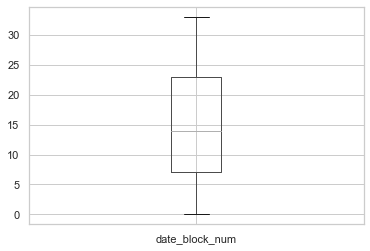

In [51]:
boxplot1 = train.boxplot(column=['date_block_num'])

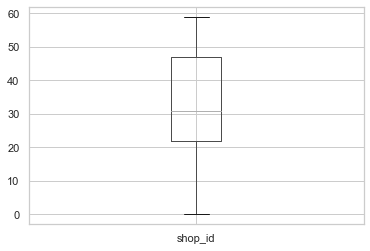

In [52]:
boxplot2 = train.boxplot(column=['shop_id'])

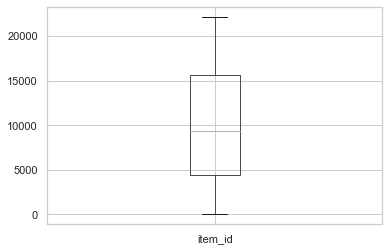

In [53]:
boxplot3 = train.boxplot(column=['item_id'])

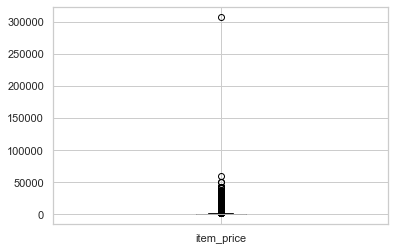

In [54]:
boxplot4 = train.boxplot(column=['item_price'])

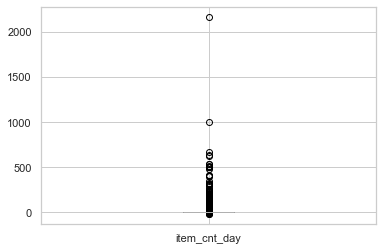

In [55]:
boxplot5 = train.boxplot(column=['item_cnt_day'])

In [56]:
train.skew()

C:\Users\F5469333\AppData\Local\Temp/ipykernel_17056/3574648760.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train.skew()


date_block_num      0.203858
shop_id            -0.072361
item_id             0.257174
item_price         10.750423
item_cnt_day      272.833162
dtype: float64

In [57]:
train.kurtosis()

C:\Users\F5469333\AppData\Local\Temp/ipykernel_17056/1855142227.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train.kurtosis()


date_block_num        -1.082869
shop_id               -1.025358
item_id               -1.225210
item_price           445.532826
item_cnt_day      177478.098774
dtype: float64

In [58]:
train.corr()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
date_block_num,1.000000,0.019273,0.009356,0.095010,0.009402
shop_id,0.019273,1.000000,0.029396,-0.024034,-0.005230
item_id,0.009356,0.029396,1.000000,-0.134104,0.016650
item_price,0.095010,-0.024034,-0.134104,1.000000,0.011197
item_cnt_day,0.009402,-0.005230,0.016650,0.011197,1.000000


<AxesSubplot:>

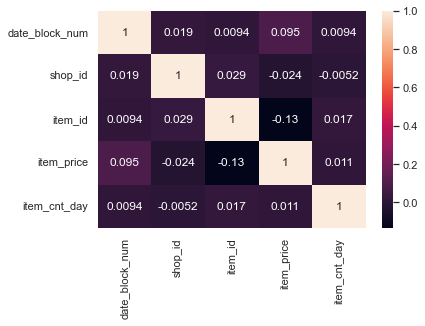

In [59]:
sns.heatmap(train.corr(),annot=True)

# Data Engineering

In [60]:
# Get maximum number in column 'date_block_num' representing the last month in data
train_max_month = train.date_block_num.max()

# Add column 'date_block_num' to the test dataset. The values would be sales_train_max_month + 1 representing next month
test['date_block_num'] = train_max_month + 1

# Create temp table to concat modified sales_train and test datasets
sales_temp = pd.concat([train,test])

# Create monthly sales data by aggregating on column 'item_cnt_day' and then rename column to 'item_cnt_month'
sales_monthly = sales_temp.groupby(by = ['date_block_num','shop_id','item_id'], as_index=False).agg({'item_cnt_day':'sum'})
sales_monthly = sales_monthly.rename(columns={'item_cnt_day':'item_cnt_month'})

In [61]:
# Add new lag column 'lag_item_cnt_month' by shifting values from 'item_cnt_month' by 1
sales_monthly['lag_item_cnt_month'] = sales_monthly['item_cnt_month'].shift(1)

# Remove na values in the lag column
sales_monthly.fillna(0, inplace=True)
sales_monthly.isna().sum()

date_block_num        0
shop_id               0
item_id               0
item_cnt_month        0
lag_item_cnt_month    0
dtype: int64

In [65]:
# The 'date_block_num' must be split as contiguos months of training data and validation data
split_ratio = 0.8
train_valid_split = np.floor(train_max_month*split_ratio)
train_data = sales_monthly[sales_monthly['date_block_num'] <= train_valid_split]
valid_data = sales_monthly[(sales_monthly['date_block_num'] > train_valid_split) & (sales_monthly['date_block_num'] < train_max_month+1)]

# Test data will be the 'date_block_num' is sales_train_max_month+1
test_data = sales_monthly[sales_monthly['date_block_num'] == train_max_month+1]

In [83]:
train_data.head()

,date_block_num,shop_id,item_id,item_cnt_month,lag_item_cnt_month
0,0,0,32,6.0,0.0
1,0,0,33,3.0,6.0
2,0,0,35,1.0,3.0
3,0,0,43,1.0,1.0
4,0,0,51,2.0,1.0


In [84]:
test_data.head()

,date_block_num,shop_id,item_id,item_cnt_month,lag_item_cnt_month
1609124,34,2,30,0.0,1.0
1609125,34,2,31,0.0,0.0
1609126,34,2,32,0.0,0.0
1609127,34,2,33,0.0,0.0
1609128,34,2,38,0.0,0.0


In [85]:
test_data.drop(['item_cnt_month'],axis=1)

,date_block_num,shop_id,item_id,lag_item_cnt_month
1609124,34,2,30,1.0
1609125,34,2,31,0.0
1609126,34,2,32,0.0
1609127,34,2,33,0.0
1609128,34,2,38,0.0
...,...,...,...,...
1823319,34,59,22162,0.0
1823320,34,59,22163,0.0
1823321,34,59,22164,0.0
1823322,34,59,22166,0.0


In [86]:
X = train_data.drop('item_cnt_month',axis=1)
y = train_data['item_cnt_month']

In [87]:
from sklearn.model_selection import train_test_split

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

In [89]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

In [90]:
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [91]:
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import math

In [92]:
results_dict = {'Training MSE':
                    {
                        "MLR": metrics.mean_squared_error(y_train, rf.predict(X_train))
                    },
                'Test MSE':
                    {
                        "MLR": metrics.mean_squared_error(y_test, rf.predict(X_test))
                    },
                'Test RMSE':
                    {
                        "MLR": math.sqrt(metrics.mean_squared_error(y_test, rf.predict(X_test)))
                    }
                }

In [93]:
results_df = pd.DataFrame(data=results_dict)
results_df

,Training MSE,Test MSE,Test RMSE
MLR,3.91873,20.876752,4.569108
